In [6]:
!wget https://github.com/garythung/trashnet/raw/master/data/dataset-resized.zip

--2019-12-31 16:11:47--  https://github.com/garythung/trashnet/raw/master/data/dataset-resized.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/garythung/trashnet/master/data/dataset-resized.zip [following]
--2019-12-31 16:11:48--  https://raw.githubusercontent.com/garythung/trashnet/master/data/dataset-resized.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42834870 (41M) [application/zip]
Saving to: ‘dataset-resized.zip.1’

dataset-resized.zip 100%[===================>]  40.85M   156MB/s    in 0.3s    

2019-12-31 16:11:48 (156 MB/s) - ‘dataset-resized.zip.1’ saved [42834870/42834870]



In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns

In [0]:
files = zf.ZipFile("dataset-resized.zip",'r')
files.extractall()
files.close()

In [10]:
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['trash', 'glass', 'paper', 'cardboard', 'metal', '.DS_Store', 'plastic']

In [0]:
## helper functions ##

## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [0]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"data/test")

In [13]:
## get a path to the folder with images
path = Path(os.getcwd())/"data"
path

PosixPath('/content/data')

In [0]:
## apply transformations to data
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=16)

In [15]:
data

ImageDataBunch;

Train: LabelList (1262 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
trash,trash,trash,trash,trash
Path: /content/data;

Valid: LabelList (630 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
trash,trash,trash,trash,trash
Path: /content/data;

Test: LabelList (635 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: /content/data

In [16]:
data.show_batch(rows=4,figsize=(10,8))

Output hidden; open in https://colab.research.google.com to view.

In [17]:
learn = create_cnn(data,models.resnet18,metrics=error_rate,callback_fns=ShowGraph)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 69.6MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


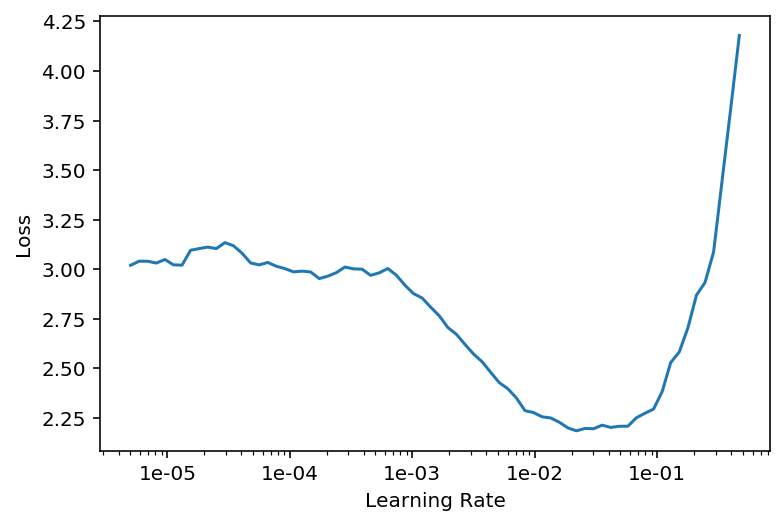

In [18]:
learn.lr_find(start_lr=1e-6,end_lr=1e1)
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,time
0,1.701557,0.757793,0.261905,00:28
1,1.090835,0.574782,0.177778,00:28
2,0.932593,0.541056,0.165079,00:28
3,0.863821,0.460433,0.161905,00:28
4,0.794919,0.515146,0.165079,00:28
5,0.784935,0.605501,0.174603,00:28
6,0.763134,0.614761,0.176190,00:28
7,0.737595,0.473638,0.161905,00:28
8,0.702753,0.477993,0.160317,00:28
9,0.573809,0.472172,0.161905,00:28


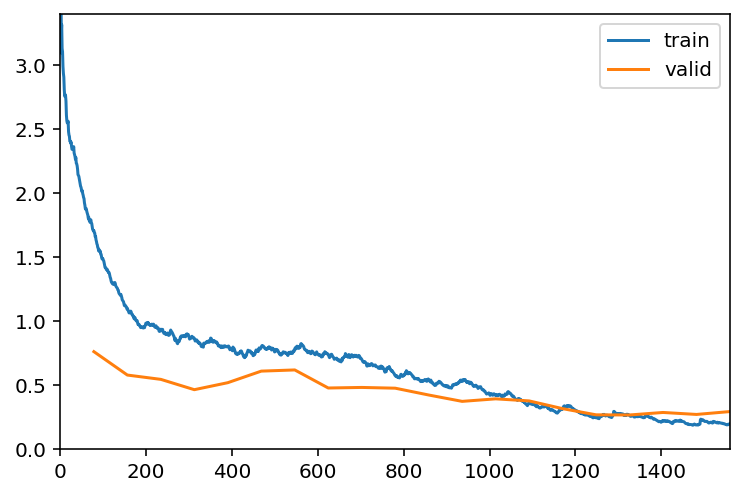

In [19]:
learn.fit_one_cycle(20,max_lr=5.13e-03)

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

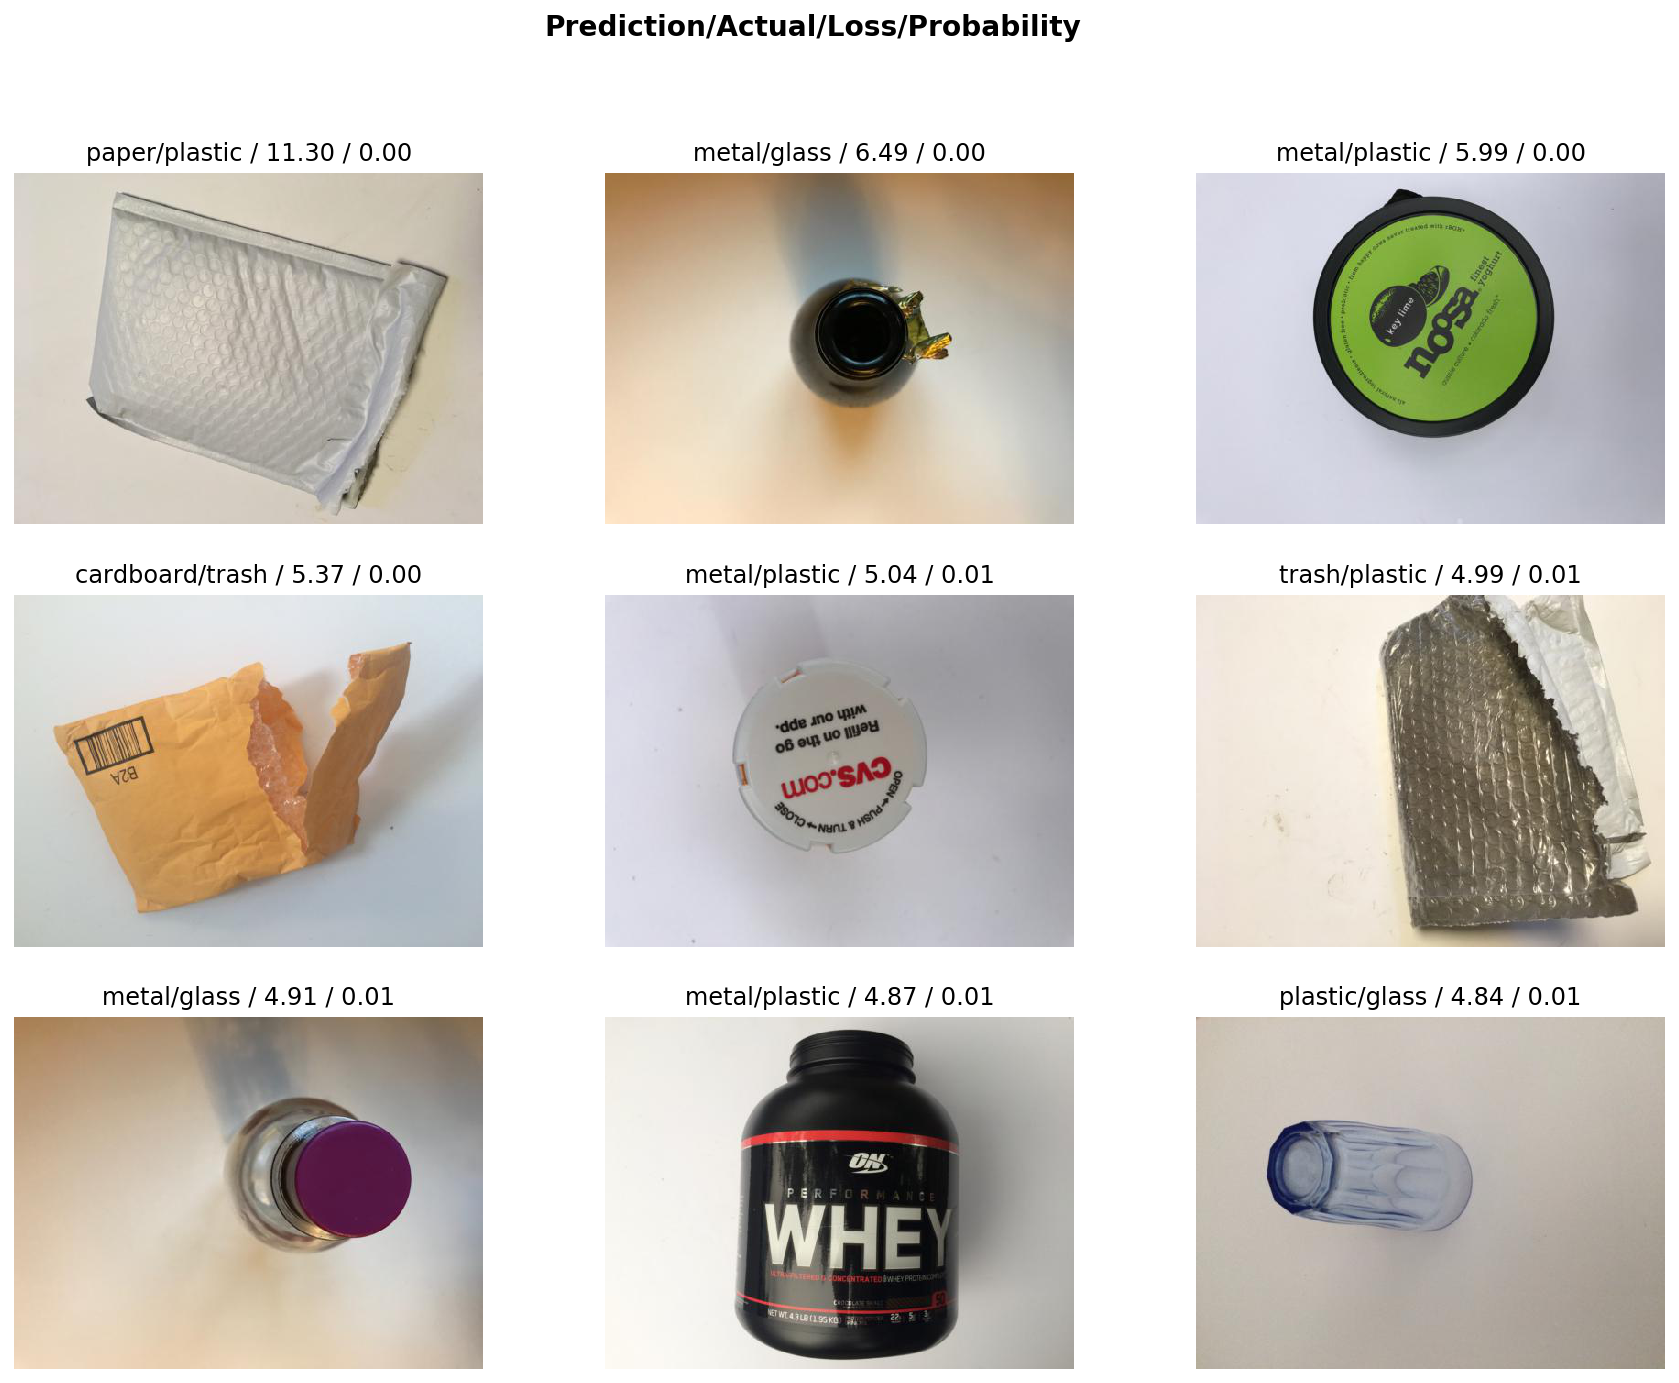

In [21]:
interp.plot_top_losses(9, figsize=(15,11))

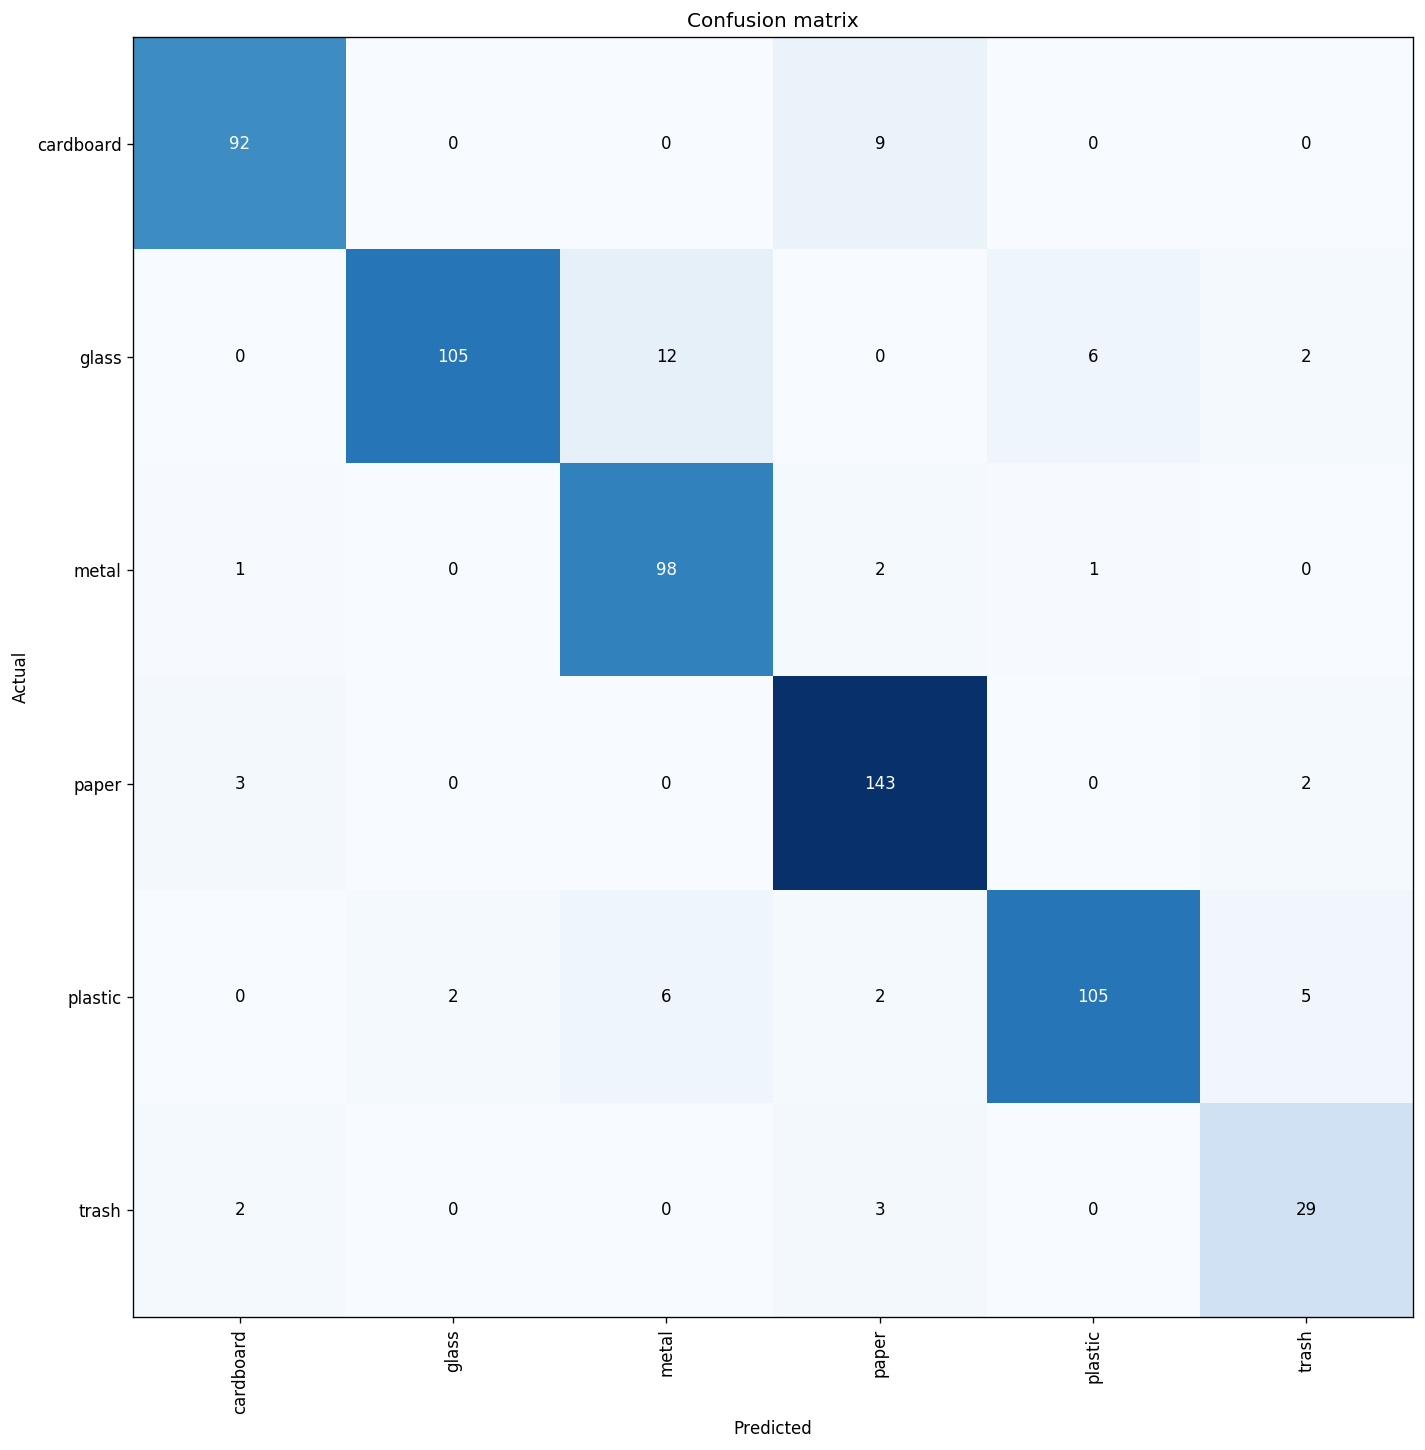

In [22]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [23]:
interp.most_confused(min_val=2)

[('glass', 'metal', 12),
 ('cardboard', 'paper', 9),
 ('glass', 'plastic', 6),
 ('plastic', 'metal', 6),
 ('plastic', 'trash', 5),
 ('paper', 'cardboard', 3),
 ('trash', 'paper', 3),
 ('glass', 'trash', 2),
 ('metal', 'paper', 2),
 ('paper', 'trash', 2),
 ('plastic', 'glass', 2),
 ('plastic', 'paper', 2),
 ('trash', 'cardboard', 2)]

In [24]:
preds = learn.get_preds(ds_type=DatasetType.Test)

In [25]:
print(preds[0].shape)
preds[0]

torch.Size([635, 6])


tensor([[6.1197e-04, 8.2027e-01, 1.6194e-01, 3.9581e-03, 1.3208e-02, 3.0284e-06],
        [2.4885e-04, 6.2264e-07, 2.9432e-08, 9.9973e-01, 1.6457e-05, 3.6287e-07],
        [3.3265e-03, 2.3050e-06, 7.0649e-05, 9.9609e-01, 4.2531e-05, 4.6501e-04],
        ...,
        [1.2520e-03, 2.1621e-01, 1.2539e-03, 8.8931e-04, 7.8026e-01, 1.2815e-04],
        [1.0000e+00, 9.4130e-12, 1.0222e-11, 8.0654e-08, 2.9752e-08, 7.0327e-08],
        [2.6191e-06, 6.1479e-07, 1.3189e-06, 9.9996e-01, 2.9274e-05, 7.2863e-06]])

In [0]:
max_idxs = np.asarray(np.argmax(preds[0],axis=1))

In [0]:
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])

In [28]:
yhat

['glass',
 'paper',
 'paper',
 'plastic',
 'paper',
 'cardboard',
 'glass',
 'trash',
 'glass',
 'paper',
 'metal',
 'cardboard',
 'plastic',
 'paper',
 'paper',
 'metal',
 'plastic',
 'paper',
 'paper',
 'cardboard',
 'plastic',
 'cardboard',
 'cardboard',
 'plastic',
 'paper',
 'plastic',
 'glass',
 'paper',
 'paper',
 'paper',
 'plastic',
 'metal',
 'glass',
 'paper',
 'metal',
 'plastic',
 'trash',
 'plastic',
 'metal',
 'trash',
 'glass',
 'cardboard',
 'trash',
 'metal',
 'cardboard',
 'paper',
 'trash',
 'metal',
 'metal',
 'plastic',
 'cardboard',
 'glass',
 'plastic',
 'paper',
 'paper',
 'cardboard',
 'paper',
 'metal',
 'paper',
 'trash',
 'metal',
 'glass',
 'metal',
 'cardboard',
 'metal',
 'cardboard',
 'glass',
 'plastic',
 'trash',
 'trash',
 'glass',
 'paper',
 'metal',
 'paper',
 'plastic',
 'paper',
 'metal',
 'metal',
 'paper',
 'metal',
 'plastic',
 'metal',
 'cardboard',
 'metal',
 'metal',
 'cardboard',
 'paper',
 'trash',
 'paper',
 'metal',
 'glass',
 'paper',


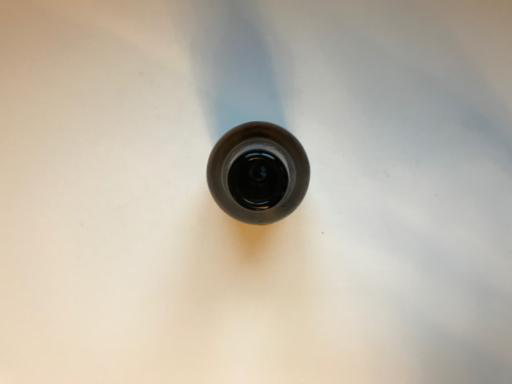

In [29]:
learn.data.test_ds[0][0]

In [0]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

In [31]:
## predicted values
print(yhat[0:5])
## actual values
print(y[0:5])

['glass', 'paper', 'paper', 'plastic', 'paper']
['glass', 'paper', 'paper', 'plastic', 'paper']


In [32]:
cm = confusion_matrix(y,yhat)
print(cm)

[[ 95   0   1   4   0   1]
 [  0 101  15   1   9   0]
 [  1   4  93   0   3   2]
 [  0   1   0 146   0   2]
 [  0   4   0   3 110   4]
 [  1   0   0   2   3  29]]


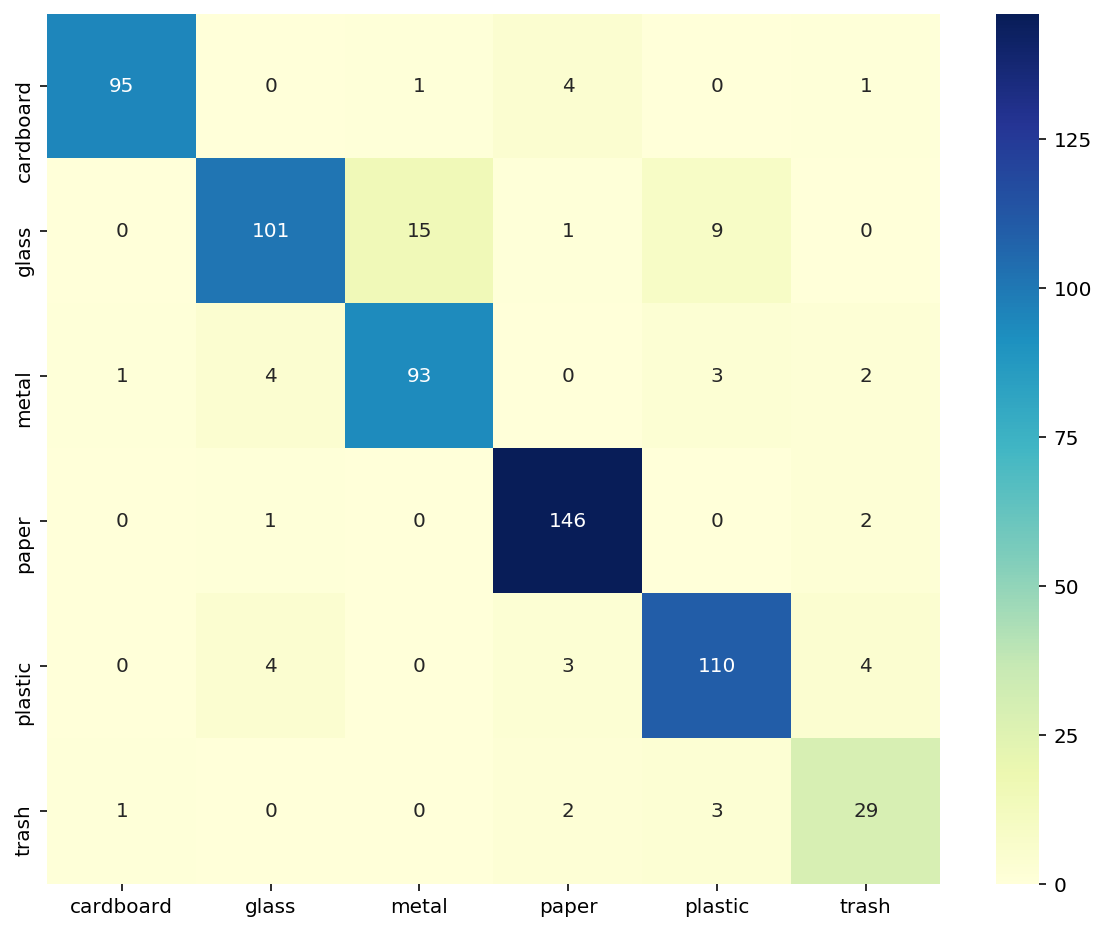

In [33]:
df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

In [0]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

In [35]:
accuracy = correct/sum(sum(cm))
accuracy

0.9039370078740158